In [1]:
## ---- Partition Cell Set Network Module Plotting ---- 0683.00.00
## Load Analysis Parameters (Parm1)
## Load Network Utilities
## Loop Through Partitions 2 and 3, Loading Medium Density Networks
## Loop Through Partitions 2 and 3, Loading High Density Networks
## Use Network Plotting Strategy To Replot Medium and High Density Networks

In [1]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [2]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [3]:
## Read the GENCODE v27 Data
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)

## Get the igraph utilities
source('/gpfs/home/devans/code/Utilities/fromSara/setup_igraph.r')
source('/gpfs/home/devans/code/Utilities/fromSara/recursive_louvain.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_score.r')
source('/gpfs/home/devans/code/Utilities/fromSara/cluster_overlap.r')
source('/gpfs/home/devans/code/Utilities/fromSara/plot_by_cluster.r')

# Hex vertex shape, with a parameter for edges = 3 to get a hex
myhex <- function(coords, v=NULL, params) {
   vertex.color <- params("vertex", "color")
   if (length(vertex.color) != 1 && !is.null(v)) {
      vertex.color <- vertex.color[v]
   }  
    
   vertex.frame.color <- params("vertex", "frame.color")
   if (length(vertex.frame.color) != 1 && !is.null(v)) {
        vertex.frame.color <- vertex.frame.color[v]
   } 
    
   vertex.size  <- 1/200 * params("vertex", "size")
   if (length(vertex.size) != 1 && !is.null(v)) {
      vertex.size <- vertex.size[v]
   }
   norays <- params("vertex", "norays")
   if (length(norays) != 1 && !is.null(v)) {
      norays <- norays[v]
   }

   mapply(coords[,1], coords[,2], vertex.color, vertex.frame.color, vertex.size, norays,
          FUN=function(x, y, bg, fg, size, nor) {
             symbols(x=x, y=y, bg=bg, fg = fg,
                     stars=matrix(c(size,size), nrow=1, ncol=nor*2),
                     add=TRUE, inches=FALSE)
          })
}
# no clipping, edges will be below the vertices anyway
add_shape("hex", clip=shape_noclip,
          plot=myhex, parameters=list(vertex.norays=3))

In [6]:
## Read the previously preprocessed downsampled cell set data object
setwd(datdir)
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [7]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

## Medium Density Network Plots, with Updated Parameters

In [75]:
## This is for the medium density networks
# Specify the partition and module and plot it
p <- 3

## Other control parameter(s)
diff_exp_qval_cut <- 0.05
    
## Set up directory path and files as needed
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')) 

## Read partition cell data set, expression data, and diff expression data
partn_cds <- readRDS('Partition.Cell.Set.rds')
partn_exp <- t(exprs(partn_cds))
de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)    

## Read everything related to partition network    
net2 <- readRDS('Network.2k.rds')
net2_clust <- readRDS('Louvain.Clust.2k.rds')
clust_sc <- readRDS('Louvain.Clust.Score.2k.rds')

## Remove DE genes that are duplicates and add vertex attribute with the DE q values
net_genes <- V(net2)$v27
dups <- duplicated(de_tab$gene_short_name)
de_tab_dups <- de_tab$gene_short_name[dups]
dup_idxs <- which(de_tab$gene_short_name %in% de_tab_dups)
idx_2_rmv <- vector(mode = 'integer', length = length(de_tab_dups))
j <- 1
for (i in 1:length(de_tab_dups)) {
    if (de_tab$q_value[j] <= de_tab$q_value[j + 1]) idx_2_rmv[i] <- dup_idxs[j + 1]
    else idx_2_rmv[i] <- dup_idxs[j]
    j <- j + 2
}
de_tab_rmdups <- de_tab[-idx_2_rmv,]
rownames(de_tab_rmdups) <- de_tab_rmdups$gene_short_name
V(net2)$de_qval <- de_tab_rmdups[V(net2)$v27,10]
V(net2)[is.na(V(net2)$de_qval)]$de_qval <- 1
de_tab <- de_tab_rmdups


## Get the significant differential expressed terms
qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
    dplyr::select(gene_short_name, normalized_effect, q_value)

## Recolor significant DE genes, inverting red and green from what's in net2
V(net2)$color <- rgb(.5, .5, .5, alpha = .5)  # Gray
gene2ne <- qsig$normalized_effect
names(gene2ne) <- qsig$gene_short_name
gene2ne <- gene2ne/max(abs(gene2ne))
gene2ne_p <- 1 - round(gene2ne[gene2ne > 0], 3)
gene2ne_m <- 1 - round(-gene2ne[gene2ne < 0], 3)

V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <-                     # Cyan
    rgb(gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 1, 1, alpha = .5) 
V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <-                     # Red
    rgb(1, gene2ne_m[names(gene2ne_m) %in% V(net2)$v27],
        gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)

## Populate the partition nodes (genes) with their Diff Exp Status
## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
rownames(qsig) <- short2geneid[qsig[,1]]
V(net2)$diffexp <- 0
genes <- V(net2)$name
for (gene in 1:length(genes)) {
    de <- qsig[genes[gene],]
if (!is.na(de[1])) {
    V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
    }
}

In [76]:
## Get the cell type network and show the module sizes

scale <- 3
nodescale <- .3

g <- net2
set.seed(101)
# layout <- layout_with_gem(g) * .5

V(g)$size <- 15 * 3 / 5 * nodescale * .5
# V(g)$color <- 'skyblue2'
V(g)$frame.color <- '#FFFF0080'  # 'black'
V(g)$shape <- 'circle'
V(g)$label <- V(g)$v27 ## Overwrite what is stored in the network, which includes the strength
# V(g)$label.family <- 'helvetica'
V(g)$label.font <- 1
V(g)$label.cex <- 1. * .22 * scale * nodescale
V(g)$label.color <- 'black'
# E(g)$color <- 'darkgray'
E(g)$width <- 1 * scale * nodescale
E(g)$lty <- 1
E(g)$label <- NA
# E(g)$label.family <- 'helvetica'
E(g)$label.font <- 1
E(g)$label.cex <- 1
E(g)$label.color <- 'skyblue2'
E(g)$curved <- FALSE

# specialnodes <<- which(V(g)$v27 %in% genes_oi)
# V(g)$shape[specialnodes] <- 'csquare'
# V(g)$size[specialnodes] <- V(g)$size[specialnodes] * 1.1

V(g)$frame.color[V(g)$diffexp == -1] <- '#FF0000A0'
V(g)$frame.color[V(g)$diffexp == 0]  <- '#101010A0'
V(g)$frame.color[V(g)$diffexp == 1]  <- '#00FFFFA0'
E(g)$color[E(g)$pcor >= 0] <- '#00640080'
E(g)$color[E(g)$pcor < 0]  <- '#CC660080'
E(g)$width = 20 * abs(E(g)$pcor)

[1] 51

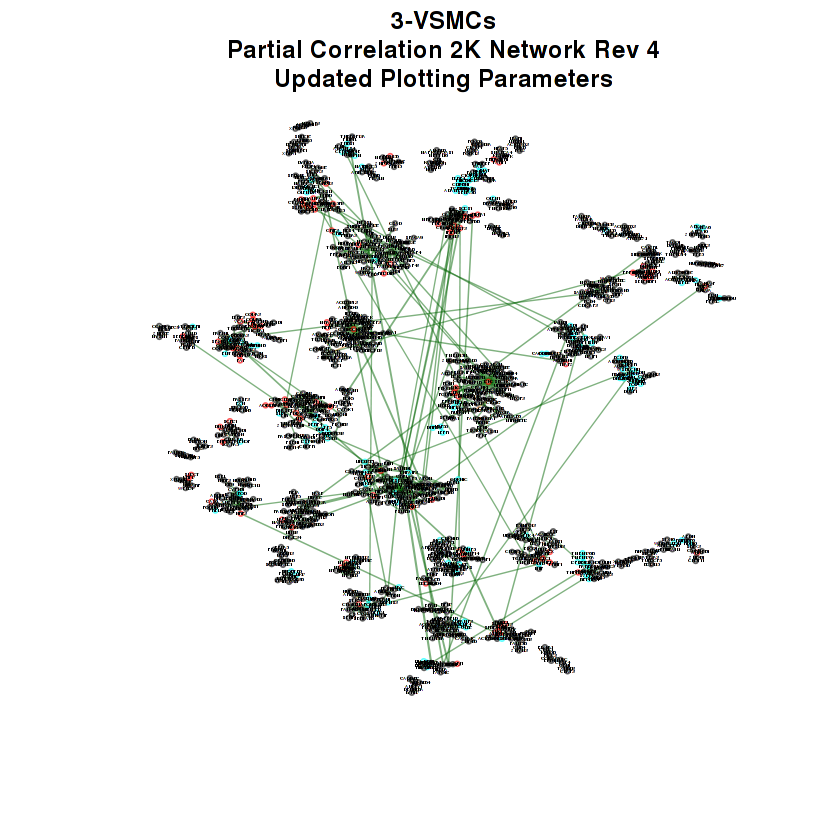

In [77]:
## Create temporary clusters to compute a component layout
## This is the list of plot algorithms
ptitle <- paste(celltypes6[p],"\nPartial Correlation 2K Network Rev 4\nUpdated Plotting Parameters", sep = '')
gs4 <- g
lmx <- c(component_wise, layout_as_bipartite, layout_as_star, layout_as_tree,
         layout_in_circle, layout_nicely, layout_on_grid, layout_on_sphere, layout_randomly,
         layout_with_dh, layout_with_fr, layout_with_gem, layout_with_graphopt, layout_with_kk,
         layout_with_lgl, layout_with_mds, layout_with_sugiyama, merge_coords, norm_coords, normalize)

lt <- layout_with_dh # layout_nicely # layout_with_graphopt
# Create a temporary clustering object
# And break cross module links for component layout
clust_temp <- cluster_louvain(gs4)
sum(crossing(clust_temp, gs4))
gs4_temp <- delete.edges(gs4, E(gs4)[crossing(clust_temp, gs4)])
set.seed(103)
gs4_lo <- layout_components(gs4_temp, layout = lt)
gs4_lo <- layout.norm(gs4_lo, -1, 1, -1, 1)


# ## Module label color (translucent blue)
nodelabc <- rgb(0, 0, 1, alpha = .4)
# Module background color (make it clear)
polycol <- rgb(0, 1, 1, alpha = .0)

## Set up for plotting of cluster ids (x and y coordinates)
numcl <- length(clust_temp)
ctxtpos <- matrix(0, nrow = numcl, ncol = 2)
colnames(ctxtpos) <- c('x', 'y')
for (i in 1:numcl) {
    ctxtpos[i,'x'] <- max(gs4_lo[membership(clust_temp) == i, 1])
    ctxtpos[i,'y'] <- mean(gs4_lo[membership(clust_temp) == i, 2])
}
## Plot with legend and module ids




plot(gs4, layout = gs4_lo, # mark.groups = clust_temp, mark.shape = 1, mark.expand = 1.5, mark.col = polycol,
    main = ptitle)
# text(ctxtpos[,1], ctxtpos[,2], adj = c(-.25, .5), 1:numcl, cex = 1, col = nodelabc, font = 4)

In [78]:
plotfile <- paste('Medium.Density.2kNetwork.Updated.Plotting.Parameters.rev4.pdf', sep = '')   
pdf(plotfile, width = 7 * scale, height = 7 * scale)
plot(gs4, layout = gs4_lo, #  mark.groups = clust_temp, mark.shape = 1, mark.expand = 1.5, mark.col = polycol,
    main = ptitle)  
# text(ctxtpos[,1], ctxtpos[,2], adj = c(-.25, .5), 1:numcl, cex = 1, col = nodelabc, font = 4)
dev.off()


png 
  2

## High Density Network Plots, with Updated Parameters

In [122]:
## This is for the high density networks
# Specify the partition and module and plot it
p <- 3

## Other control parameter(s)
diff_exp_qval_cut <- 0.05
    
## Set up directory path and files as needed
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')) 

## Read partition cell data set, expression data, and diff expression data
partn_cds <- readRDS('Partition.Cell.Set.rds')
partn_exp <- t(exprs(partn_cds))
de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)    

## Read everything related to partition network    
net2 <- readRDS('Network.20k.rds')
net2_clust <- readRDS('Louvain.Clust.20k.rds')
clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')

## Remove DE genes that are duplicates and add vertex attribute with the DE q values
net_genes <- V(net2)$v27
dups <- duplicated(de_tab$gene_short_name)
de_tab_dups <- de_tab$gene_short_name[dups]
dup_idxs <- which(de_tab$gene_short_name %in% de_tab_dups)
idx_2_rmv <- vector(mode = 'integer', length = length(de_tab_dups))
j <- 1
for (i in 1:length(de_tab_dups)) {
    if (de_tab$q_value[j] <= de_tab$q_value[j + 1]) idx_2_rmv[i] <- dup_idxs[j + 1]
    else idx_2_rmv[i] <- dup_idxs[j]
    j <- j + 2
}
de_tab_rmdups <- de_tab[-idx_2_rmv,]
rownames(de_tab_rmdups) <- de_tab_rmdups$gene_short_name
V(net2)$de_qval <- de_tab_rmdups[V(net2)$v27,10]
V(net2)$de_normeff <- de_tab_rmdups[V(net2)$v27,8]
V(net2)[is.na(V(net2)$de_qval)]$de_qval <- 1
de_tab <- de_tab_rmdups


## Get the significant differential expressed terms
qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
    dplyr::select(gene_short_name, normalized_effect, q_value)

## Recolor significant DE genes, inverting red and green from what's in net2
V(net2)$color <- rgb(.5, .5, .5, alpha = .5)  # Gray
gene2ne <- qsig$normalized_effect
names(gene2ne) <- qsig$gene_short_name
gene2ne <- gene2ne/max(abs(gene2ne))
gene2ne_p <- 1 - round(gene2ne[gene2ne > 0], 3)
gene2ne_m <- 1 - round(-gene2ne[gene2ne < 0], 3)

V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <-                     # Cyan
    rgb(gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 1, 1, alpha = .5) 
V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <-                     # Red
    rgb(1, gene2ne_m[names(gene2ne_m) %in% V(net2)$v27],
        gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)

## Populate the partition nodes (genes) with their Diff Exp Status
## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
rownames(qsig) <- short2geneid[qsig[,1]]
V(net2)$diffexp <- 0
genes <- V(net2)$name
for (gene in 1:length(genes)) {
    de <- qsig[genes[gene],]
if (!is.na(de[1])) {
    V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
    }
}

## Create temporary clusters to compute a component layout
## This is the list of plot algorithms
ptitle <- paste(celltypes6[p],"\nPartial Correlation 20K Network Rev 5\nUpdated Plotting Parameters", sep = '')
gs4 <- net2
lmx <- c(component_wise, layout_as_bipartite, layout_as_star, layout_as_tree,
         layout_in_circle, layout_nicely, layout_on_grid, layout_on_sphere, layout_randomly,
         layout_with_dh, layout_with_fr, layout_with_gem, layout_with_graphopt, layout_with_kk,
         layout_with_lgl, layout_with_mds, layout_with_sugiyama, merge_coords, norm_coords, normalize)

# lt <- layout_with_gene # layout_with_dh # layout_nicely # layout_with_graphopt
lt <- layout_with_dh # layout_nicely # layout_with_graphopt
# Create a temporary clustering object
# And break cross module links for component layout
clust_temp <- cluster_louvain(gs4)
sum(crossing(clust_temp, gs4))
gs4_temp <- delete.edges(gs4, E(gs4)[crossing(clust_temp, gs4)])
set.seed(103)
gs4_lo <- layout_components(gs4_temp, layout = lt)
gs4_lo <- layout.norm(gs4_lo, -1, 1, -1, 1)

[1] 10405

In [54]:
## Plot with legend and module ids
plotfile <- paste('High.Density.20kNetwork.Updated.Plotting.Parameters.rev5.pdf', sep = '') 
pdf(plotfile, width = scs[3], height = scs[3])
plot(gs4_temp, layout = gs4_lo, mark.groups = clust_temp, mark.shape = 1, mark.expand = 1.5, mark.col = polycol,
    main = ptitle)
text(ctxtpos[,1], ctxtpos[,2], adj = c(-.25, .5), 1:numcl, cex = 1, col = nodelabc, font = 4)
dev.off()

png 
  2

In [117]:
## Create Node Data Frame of Network and Save
V(gs4)$cluster_id <- membership(clust_temp)
V(gs4)$label <- gsub('\n', '-', gs4_node_df$label)
gs4_node_df <- as.data.frame(vertex_attr(gs4))
node_file <- 'High.Density.20kNetwork.Nodes.Updated.Plotting.Parameters.rev5.tsv'
write.table(gs4_node_df, file = node_file, row.names = FALSE,
            quote = TRUE, col.names = TRUE, sep = '\t')


Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”


In [118]:
## Create Edge Data Frame of Network and Save
E(gs4)$crossing <- crossing(clust_temp, gs4)
E(gs4)$edges <- as.character(paste(as_edgelist(gs4, names = TRUE)[1:length(E(gs4))],
                      as_edgelist(gs4, names = TRUE)[(length(E(gs4)) + 1):(length(E(gs4)) * 2)], sep = ':'))
gs4_edge_df <- as.data.frame(edge_attr(gs4))
edge_file <- 'High.Density.20kNetwork.Edges.Updated.Plotting.Parameters.rev5.tsv'
write.table(gs4_edge_df, file = edge_file, row.names = FALSE,
            quote = TRUE, col.names = TRUE, sep = '\t')

In [133]:
gs4_node_df[1,]

name            v27    v27type        strength  degree      mean     sd      
1 ENSG00000187634 SAMD11 protein_coding 0.2763089 0.001058341 88.90196 2385.808
  cv      med gene            ⋯ strtpos endpos color     label.cex label       
1 26.8364 1   ENSG00000187634 ⋯ 923928  944581 #80808080 0.1       SAMD11-0.276
  size de_qval de_normeff diffexp cluster_id
1 1    1       0.4610849  0       3

In [134]:
gs4_edge_df[1,]

pcor        pval         qval         lfdr        ord      row col  idx arank
1 -0.04861797 5.887999e-09 0.0003630678 0.002771034 33311498 15  2698 1   537  
  weight     color  label.cex width    label   crossing
1 0.04861797 orange 0.1       4.861797 -0.0486 FALSE   
  edges                          
1 ENSG00000221978:ENSG00000231074

In [20]:
p <- 3

## Other control parameter(s)
diff_exp_qval_cut <- 0.05

## Read partition cell data set, expression data, and diff expression data
partn_cds <- readRDS('Partition.Cell.Set.rds')
partn_exp <- t(exprs(partn_cds))
de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)    

## Read everything related to partition network    
net2 <- readRDS('Network.20k.rds')
net2_clust <- readRDS('Louvain.Clust.20k.rds')
clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')
    
## Set up directory path and files as needed
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')) 
mod9_interferon <- read.table('Mod9.Interferon.signaling.DE.Genes.txt', header = TRUE,
                         stringsAsFactors = FALSE, skip = 2, sep = '\t') 

In [41]:
# unique(mod9_interferon[mod9_interferon[,1] %in% (geneid2short[unlist(net2_clust[9])]),1])
geneid2short[unlist(net2_clust[9])][geneid2short[unlist(net2_clust[9])] %in% unique(mod9_interferon[,1])]
unique(mod9_interferon[,1])
geneid2short[unlist(net2_clust[9])]

ENSG00000187608 ENSG00000126709 ENSG00000115415 ENSG00000125347 ENSG00000204264 
          ISG15            IFI6           STAT1            IRF1           PSMB8 
ENSG00000168394 ENSG00000185201 ENSG00000185885 ENSG00000142089 ENSG00000119917 
           TAP1          IFITM2          IFITM1          IFITM3           IFIT3 
ENSG00000185745 ENSG00000089127 ENSG00000185338 ENSG00000068079 ENSG00000157601 
          IFIT1            OAS1           SOCS1           IFI35             MX1 
33514 Levels: A1BG A1BG-AS1 A1CF A2M A2M-AS1 A2ML1 A2ML1-AS1 A2ML1-AS2 ... ZZEF1

[1] "BAK"            "BAX"            "BCL-2"          "DRIP150"       
 [5] "Glucocorticoid" "IFI6"           "IFI35"          "IFIT1"         
 [9] "IFIT3"          "IFITM1"         "IFITM2"         "IFITM3"        
[13] "IFN α/β"        "IFNγ"           "IFNγ Rα"        "IFNγ Rβ"       
[17] "IFNA R1"        "IFNA R2"        "IRF1"           "IRF9"          
[21] "ISG15"          "ISGF3"          "JAK1"           "JAK2"          
[25] "MX1"            "NF-κB p65"      "OAS1"           "PIAS1"         
[29] "PSMB8"          "SOCS1"          "STAT1"          "STAT2"         
[33] "Stat1 dimer"    "Stat1-Stat2"    "TAP1"           "TC-PTP"        
[37] "TYK2"

ENSG00000187608 ENSG00000204178 ENSG00000157978 ENSG00000126709 ENSG00000204138 
          ISG15           MACO1         LDLRAP1            IFI6         PHACTR4 
ENSG00000004455 ENSG00000146463 ENSG00000126067 ENSG00000162373 ENSG00000134748 
            AK2           ZMYM4           PSMB2           BEND5         PRPF38A 
ENSG00000116754 ENSG00000132485 ENSG00000137959 ENSG00000142867 ENSG00000183291 
         SRSF11          ZRANB2          IFI44L           BCL10         SELENOF 
ENSG00000117226 ENSG00000117228 ENSG00000162645 ENSG00000162654 ENSG00000162692 
           GBP3            GBP1            GBP2            GBP4           VCAM1 
ENSG00000064886 ENSG00000116774 ENSG00000116815 ENSG00000163131 ENSG00000188015 
         CHI3L2          OLFML3            CD58            CTSS          S100A3 
ENSG00000143554 ENSG00000196189 ENSG00000160783 ENSG00000132716 ENSG00000117143 
        SLC27A3          SEMA4A            PMF1           DCAF8            UAP1 
ENSG00000198771 ENSG00000094975 ENSG00000135823 ENSG00000116741 ENSG00000117625 
          RCSD1            SUCO            STX6            RGS2           RCOR3 
ENSG00000119280 ENSG00000130508 ENSG00000119185 ENSG00000205795 ENSG00000134318 
       C1orf198            PXDN        ITGB1BP1            CYS1           ROCK2 
ENSG00000114978 ENSG00000168906 ENSG00000168899 ENSG00000115073 ENSG00000135974 
          MOB1A           MAT2A           VAMP5          ACTR1B         C2orf49 
ENSG00000119147 ENSG00000272667 ENSG00000136718 ENSG00000115963 ENSG00000123610 
        C2orf40      AC012306.2            IMP4            RND3         TNFAIP6 
ENSG00000162980 ENSG00000115267 ENSG00000128656 ENSG00000116095 ENSG00000003436 
          ARL5A           IFIH1            CHN1         PLEKHA3            TFPI 
ENSG00000115415 ENSG00000173559 ENSG00000115540 ENSG00000118263 ENSG00000144579 
          STAT1           NABP1            MOB4            KLF7          CTDSP1 
ENSG00000115661 ENSG00000065802 ENSG00000122085 ENSG00000134107 ENSG00000163703 
          STK16            ASB1          MTERF4         BHLHE40          CRELD1 
ENSG00000157150 ENSG00000164091 ENSG00000169379 ENSG00000066422 ENSG00000144802 
          TIMP4           WDR82          ARL13B          ZBTB11          NFKBIZ 
ENSG00000173193 ENSG00000075785 ENSG00000114115 ENSG00000188313 ENSG00000047457 
         PARP14           RAB7A            RBP1          PLSCR1              CP 
ENSG00000075420 ENSG00000121858 ENSG00000180370 ENSG00000131127 ENSG00000185049 
         FNDC3B         TNFSF10            PAK2          ZNF141           NELFA 
ENSG00000168818 ENSG00000178988 ENSG00000002549 ENSG00000090989 ENSG00000081041 
          STX18        MRFAP1L1            LAP3           EXOC1           CXCL2 
ENSG00000138755 ENSG00000169245 ENSG00000138758 ENSG00000138764 ENSG00000163644 
          CXCL9          CXCL10          SEPT11           CCNG2           PPM1K 
ENSG00000168785 ENSG00000138821 ENSG00000151466 ENSG00000198589 ENSG00000129128 
         TSPAN5         SLC39A8           SCLT1            LRBA           SPCS3 
ENSG00000164151 ENSG00000164318 ENSG00000112964 ENSG00000112992 ENSG00000085365 
           ICE1          EGFLAM             GHR             NNT          SCAMP1 
ENSG00000173221 ENSG00000118985 ENSG00000145743 ENSG00000145779 ENSG00000125347 
           GLRX            ELL2          FBXL17         TNFAIP8            IRF1 
ENSG00000145819 ENSG00000145901 ENSG00000213316 ENSG00000161013 ENSG00000137414 
       ARHGAP26           TNIP1           LTC4S          MGAT4B          FAM8A1 
ENSG00000112312 ENSG00000112343 ENSG00000180573 ENSG00000137331 ENSG00000204371 
           GMNN          TRIM38       HIST1H2AC            IER3           EHMT2 
ENSG00000204264 ENSG00000240065 ENSG00000168394 ENSG00000112514 ENSG00000137193 
          PSMB8           PSMB9            TAP1            CUTA            PIM1 
ENSG00000124541 ENSG00000096080 ENSG00000083123 ENSG00000111880 ENSG00000112320 
          RRP36         MRPS18A

## VSMC Network Plots Module 9 Interferon Signaling from IPA

In [ ]:
## This is for the high density networks
# Specify the partition and module and plot it
p <- 3

## Other control parameter(s)
diff_exp_qval_cut <- 0.05
    
## Set up directory path and files as needed
setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = '')) 

## Read partition cell data set, expression data, and diff expression data
partn_cds <- readRDS('Partition.Cell.Set.rds')
partn_exp <- t(exprs(partn_cds))
de_tab <- read.table('Diff.AllHealthCoeff.RemoveFail.NoModels.txt', header = TRUE,
                         stringsAsFactors = FALSE)    

## Read everything related to partition network    
net2 <- readRDS('Network.20k.rds')
net2_clust <- readRDS('Louvain.Clust.20k.rds')
clust_sc <- readRDS('Louvain.Clust.Score.20k.rds')

## Read the module 9 Interferon Genes
mod9_interferon <- read.table('Mod9.Interferon.signaling.DE.Genes.txt', header = TRUE,
                         stringsAsFactors = FALSE, skip = 2, sep = '\t')  

## Remove DE genes that are duplicates and add vertex attribute with the DE q values
net_genes <- V(net2)$v27
dups <- duplicated(de_tab$gene_short_name)
de_tab_dups <- de_tab$gene_short_name[dups]
dup_idxs <- which(de_tab$gene_short_name %in% de_tab_dups)
idx_2_rmv <- vector(mode = 'integer', length = length(de_tab_dups))
j <- 1
for (i in 1:length(de_tab_dups)) {
    if (de_tab$q_value[j] <= de_tab$q_value[j + 1]) idx_2_rmv[i] <- dup_idxs[j + 1]
    else idx_2_rmv[i] <- dup_idxs[j]
    j <- j + 2
}
de_tab_rmdups <- de_tab[-idx_2_rmv,]
rownames(de_tab_rmdups) <- de_tab_rmdups$gene_short_name
V(net2)$de_qval <- de_tab_rmdups[V(net2)$v27,10]
V(net2)[is.na(V(net2)$de_qval)]$de_qval <- 1
de_tab <- de_tab_rmdups


## Get the significant differential expressed terms
qsig <- de_tab %>% filter(q_value < diff_exp_qval_cut) %>% 
    dplyr::select(gene_short_name, normalized_effect, q_value)

## Recolor significant DE genes, inverting red and green from what's in net2
V(net2)$color <- rgb(.5, .5, .5, alpha = .5)  # Gray
gene2ne <- qsig$normalized_effect
names(gene2ne) <- qsig$gene_short_name
gene2ne <- gene2ne/max(abs(gene2ne))
gene2ne_p <- 1 - round(gene2ne[gene2ne > 0], 3)
gene2ne_m <- 1 - round(-gene2ne[gene2ne < 0], 3)

V(net2)$color[V(net2)$v27 %in% names(gene2ne_p)] <-                     # Cyan
    rgb(gene2ne_p[names(gene2ne_p) %in% V(net2)$v27], 1, 1, alpha = .5) 
V(net2)$color[V(net2)$v27 %in% names(gene2ne_m)] <-                     # Red
    rgb(1, gene2ne_m[names(gene2ne_m) %in% V(net2)$v27],
        gene2ne_m[names(gene2ne_m) %in% V(net2)$v27], alpha = .5)

## Populate the partition nodes (genes) with their Diff Exp Status
## +1 is healthy, -1 is diseased, 0 is not significantly differentially expressed
rownames(qsig) <- short2geneid[qsig[,1]]
V(net2)$diffexp <- 0
genes <- V(net2)$name
for (gene in 1:length(genes)) {
    de <- qsig[genes[gene],]
if (!is.na(de[1])) {
    V(net2)$diffexp[gene] <- (de$normalized_effect > 0) * 2 - 1
    }
}

## Create temporary clusters to compute a component layout
## This is the list of plot algorithms
ptitle <- paste(celltypes6[p],"\nPartial Correlation 20K Network Rev 5\nUpdated Plotting Parameters", sep = '')
gs4 <- net2
lmx <- c(component_wise, layout_as_bipartite, layout_as_star, layout_as_tree,
         layout_in_circle, layout_nicely, layout_on_grid, layout_on_sphere, layout_randomly,
         layout_with_dh, layout_with_fr, layout_with_gem, layout_with_graphopt, layout_with_kk,
         layout_with_lgl, layout_with_mds, layout_with_sugiyama, merge_coords, norm_coords, normalize)

lt <- layout_with_gene # layout_with_dh # layout_nicely # layout_with_graphopt
# Create a temporary clustering object
# And break cross module links for component layout
clust_temp <- cluster_louvain(gs4)
sum(crossing(clust_temp, gs4))
gs4_temp <- delete.edges(gs4, E(gs4)[crossing(clust_temp, gs4)])
set.seed(103)
gs4_lo <- layout_components(gs4_temp, layout = lt)
gs4_lo <- layout.norm(gs4_lo, -1, 1, -1, 1)

In [ ]:
## Get the cell type network and show the module sizes
scs <- c(.4, .5, 200, .8)
g <- gs4
set.seed(101)
# layout <- layout_with_gem(g) * .5

V(g)$size <- scs[1]
# V(g)$color <- 'skyblue2'
V(g)$frame.color <- '#FFFF0080'  # 'black'
V(g)$shape <- 'circle'
V(g)$label <- V(g)$v27 ## Overwrite what is stored in the network, which includes the strength
# V(g)$label.family <- 'helvetica'
V(g)$label.font <- 1
V(g)$label.cex <- scs[2]
V(g)$label.color <- 'black'
# E(g)$color <- 'darkgray'
E(g)$width <- 1 * scs[4]
E(g)$lty <- 1
E(g)$label <- NA
# E(g)$label.family <- 'helvetica'
E(g)$label.font <- 1
E(g)$label.cex <- 1
E(g)$label.color <- 'skyblue2'
E(g)$curved <- FALSE

# specialnodes <<- which(V(g)$v27 %in% genes_oi)
# V(g)$shape[specialnodes] <- 'csquare'
# V(g)$size[specialnodes] <- V(g)$size[specialnodes] * 1.1

V(g)$frame.color[V(g)$diffexp == -1] <- '#FF0000A0'
V(g)$frame.color[V(g)$diffexp == 0]  <- '#101010A0'
V(g)$frame.color[V(g)$diffexp == 1]  <- '#00FFFFA0'
E(g)$color[E(g)$pcor >= 0] <- '#00640080'
E(g)$color[E(g)$pcor < 0]  <- '#CC660080'
E(g)$width = 20 * abs(E(g)$pcor)

## Get the network minus crossing again, this time it has updated parameters
gs4_temp <- delete.edges(g, E(gs4)[crossing(clust_temp, gs4)])
gs4 <- g

# ## Module label color (translucent blue)
nodelabc <- rgb(0, 0, 1, alpha = .4)
# Module background color (make it clear)
polycol <- rgb(0, 1, 1, alpha = .0)

## Set up for plotting of cluster ids (x and y coordinates)
numcl <- length(clust_temp)
ctxtpos <- matrix(0, nrow = numcl, ncol = 2)
colnames(ctxtpos) <- c('x', 'y')
for (i in 1:numcl) {
    ctxtpos[i,'x'] <- max(gs4_lo[membership(clust_temp) == i, 1])
    ctxtpos[i,'y'] <- mean(gs4_lo[membership(clust_temp) == i, 2])
}

In [10]:
help(read.table)

In [9]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

Matrix products: default
BLAS: /opt/applications/R/3.5.1/gnu/lib64/R/lib/libRblas.so
LAPACK: /opt/applications/R/3.5.1/gnu/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.utf8       LC_NUMERIC=C             
 [3] LC_TIME=en_US.utf8        LC_COLLATE=en_US.utf8    
 [5] LC_MONETARY=en_US.utf8    LC_MESSAGES=en_US.utf8   
 [7] LC_PAPER=en_US.utf8       LC_NAME=C                
 [9] LC_ADDRESS=C              LC_TELEPHONE=C           
[11] LC_MEASUREMENT=en_US.utf8 LC_IDENTIFICATION=C      

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] biomaRt_2.38.0              fdrtool_1.2.15             
 [3] corpcor_1.6.9               igraph_1.2.4.1             
 [5] rhdf5_2.26.2                Matrix_1.2-17              
 [7] gridExtra_2.3               ggplot2_3.3.